In [1]:
''' autor: Jazielinho '''

' autor: Jazielinho '

In [2]:
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import cv2
import lime
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb, rgb2gray, label2rgb
import pickle
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

from IPython.display import Image

import config

In [3]:
%matplotlib inline

In [4]:
BATCH_SIZE = 256

### Descargando los datos

In [5]:
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [6]:
print(f"Tamaño de los datos: {X.shape}, target: {y.shape}")

Tamaño de los datos: (60000, 28, 28, 1), target: (60000,)


In [7]:
print(f"Tamaño de los datos de test: {X_test.shape}, target: {y_test.shape}")

Tamaño de los datos de test: (10000, 28, 28, 1), target: (10000,)


### Conjunto de entrenamiento y validacion

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123456)

In [9]:
print(f"Tamaño de los datos de entrenamiento: {X_train.shape}, target: {y_train.shape}")

Tamaño de los datos de entrenamiento: (48000, 28, 28, 1), target: (48000,)


In [10]:
print(f"Tamaño de los datos de validacion: {X_val.shape}, target: {y_val.shape}")

Tamaño de los datos de validacion: (12000, 28, 28, 1), target: (12000,)


## Preparando los datos

In [11]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

In [12]:
X_train = to_rgb(X_train)
X_val = to_rgb(X_val)
X_test = to_rgb(X_test)
X_train = X_train.reshape(-1, 28, 28, 3)
X_val = X_val.reshape(-1, 28, 28, 3)
X_test = X_test.reshape(-1, 28, 28, 3)
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [13]:
X_train.shape

(48000, 28, 28, 3)

### Analizando algunos datos

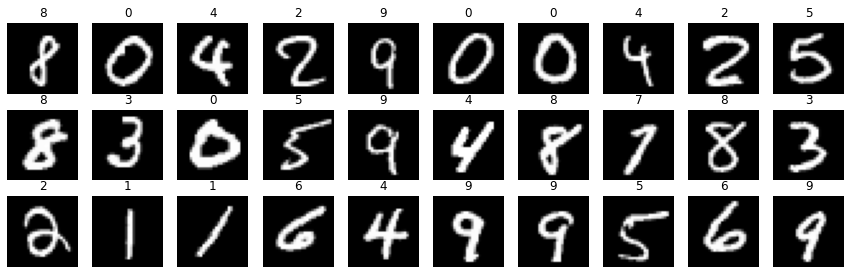

In [14]:
index_train = list(range(len(X_train)))
random.shuffle(index_train)

plt.figure(figsize=(15, 4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[index_train[i]].astype(np.uint8), cmap=plt.cm.binary)
    plt.title(np.argmax(y_train[index_train[i]]))
    plt.axis('off')
plt.show()

### Aumento de datos

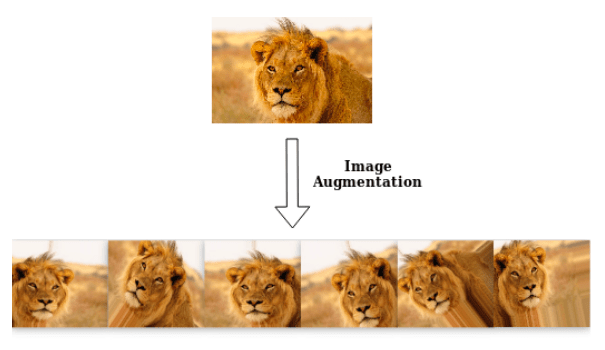

In [15]:
tr_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

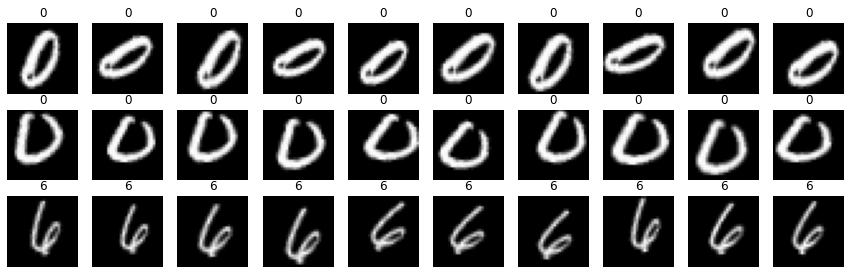

In [16]:
random.shuffle(index_train)

X_sample = X_train[index_train[0],].reshape((1, 28, 28, 3))
y_sample = y_train[index_train[0],].reshape((1, 10))

plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    X_plot, Y_plot = tr_datagen.flow(X_sample, y_sample).next()
    plt.imshow(X_plot[0].astype(np.uint8), cmap=plt.cm.binary)
    plt.title(np.argmax(y_sample))
    plt.axis('off')
    if i==9:
        X_sample = X_train[index_train[1],].reshape((1, 28, 28, 3))
        y_sample = y_train[index_train[1],].reshape((1, 10))
    if i==19:
        X_sample = X_train[index_train[2],].reshape((1, 28, 28, 3))
        y_sample = y_train[index_train[2],].reshape((1, 10))


plt.show()

In [17]:
train_datagen = tr_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

## Definiendo el modelo

In [18]:
def get_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', name='last_conv'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(10, name='embedding'))
    
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

In [19]:
model = get_model()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [21]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam')

## Entrenando modelo

In [22]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-10, verbose=1)

In [23]:
history = model.fit(train_datagen,
                    epochs=1000,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[es, rlr],
                    verbose=2)

Epoch 1/1000
187/187 - 16s - loss: 0.7033 - accuracy: 0.7803 - val_loss: 0.1293 - val_accuracy: 0.9602
Epoch 2/1000
187/187 - 16s - loss: 0.1817 - accuracy: 0.9440 - val_loss: 0.0819 - val_accuracy: 0.9768
Epoch 3/1000
187/187 - 16s - loss: 0.1267 - accuracy: 0.9608 - val_loss: 0.0790 - val_accuracy: 0.9773
Epoch 4/1000
187/187 - 16s - loss: 0.0989 - accuracy: 0.9699 - val_loss: 0.0568 - val_accuracy: 0.9835
Epoch 5/1000
187/187 - 16s - loss: 0.0881 - accuracy: 0.9739 - val_loss: 0.0409 - val_accuracy: 0.9892
Epoch 6/1000
187/187 - 16s - loss: 0.0769 - accuracy: 0.9770 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 7/1000
187/187 - 16s - loss: 0.0693 - accuracy: 0.9794 - val_loss: 0.0301 - val_accuracy: 0.9909
Epoch 8/1000
187/187 - 16s - loss: 0.0654 - accuracy: 0.9800 - val_loss: 0.0262 - val_accuracy: 0.9928
Epoch 9/1000
187/187 - 16s - loss: 0.0598 - accuracy: 0.9815 - val_loss: 0.0273 - val_accuracy: 0.9920
Epoch 10/1000
187/187 - 16s - loss: 0.0585 - accuracy: 0.9829 - val_loss:

## Evaluando el modelo

<AxesSubplot:>

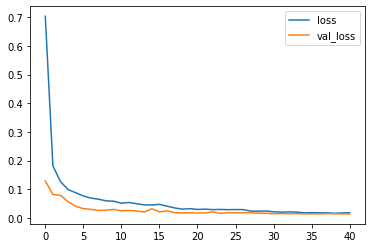

In [24]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

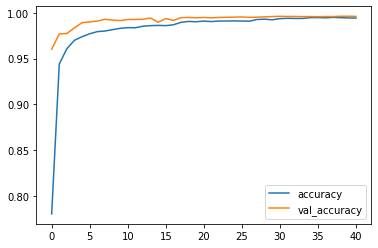

In [25]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [26]:
predict_test = model.predict(X_test, verbose=1)
predict_class = np.argmax(predict_test, axis=1)

data_test = pd.DataFrame({'pred': predict_class, 'target': np.argmax(y_test, axis=1)})

313/313 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step


In [27]:
data_test.head()

,pred,target
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [28]:
cf_matrix = confusion_matrix(data_test['target'], data_test['pred'])

<AxesSubplot:>

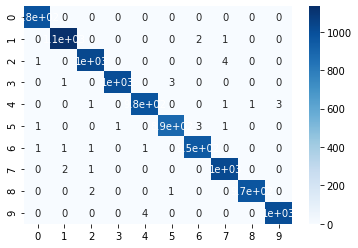

In [29]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [30]:
index_error = data_test[data_test['target'] != data_test['pred']].index.tolist()

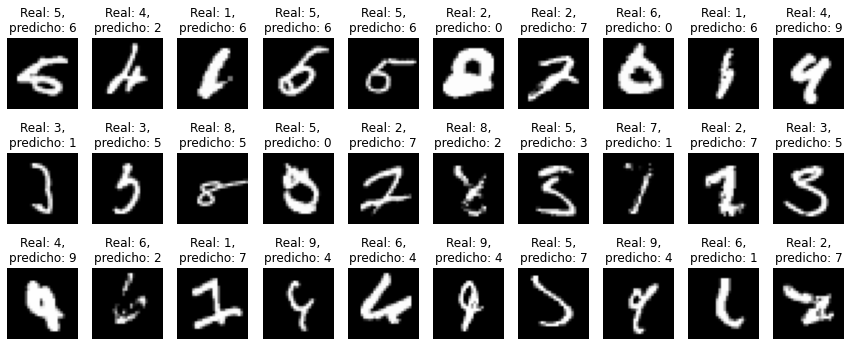

In [31]:
random.shuffle(index_error)

plt.figure(figsize=(15, 6))
for i in range(30):
    if i < len(index_error):
        real_ = np.argmax(y_test[index_error[i]])
        pred_ = predict_class[index_error[i]]
        plt.subplot(3, 10, i+1)
        plt.imshow(X_test[index_error[i]].astype(np.uint8), cmap=plt.cm.binary)
        plt.title(f"Real: {real_},\npredicho: {pred_}")
        plt.axis('off')
plt.show()

## LIME para importancia

In [32]:
explainer = lime_image.LimeImageExplainer(verbose=False, random_state=12345)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [33]:
X_eval = X_test[index_error[10]]

In [ ]:
explanation = explainer.explain_instance(X_eval, 
                                         classifier_fn=model.predict,
                                         top_labels=10, 
                                         hide_color=0,
                                         num_samples=10000, 
                                         segmentation_fn=segmenter)

In [ ]:
fig, m_axs = plt.subplots(2, 5, figsize = (12, 6))

for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask.astype(np.uint8), X_eval.astype(np.uint8), bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}'.format(i))
    c_ax.axis('off')

In [ ]:
image, mask = explanation.get_image_and_mask(
    model.predict(X_eval.reshape((1, 28, 28, 3))).argmax(axis=1)[0],
    positive_only=True,
    hide_rest=False)

In [ ]:
plt.imshow(X_eval.astype(np.uint8))
plt.imshow(mark_boundaries(image.astype(np.uint8), mask))

## Buscando imagenes similares

In [ ]:
emb_model = tf.keras.models.Model(model.input, model.get_layer('embedding').output)

In [ ]:
emb_train = emb_model.predict(X_train, verbose=1)
emb_val = emb_model.predict(X_val, verbose=1)
emb_test = emb_model.predict(X_test, verbose=1)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine')
nbrs.fit(emb_train)

In [ ]:
distances_test, pred_nearest_test = nbrs.kneighbors(emb_test)

In [ ]:
pred_nearest_test.shape

In [ ]:
random.shuffle(index_error)

plt.figure(figsize=(15, 10))

k = 0

for i in range(4):
    test_plot = X_test[index_error[i]]
    similars = pred_nearest_test[index_error[i],:].ravel()
    real_ = np.argmax(y_test[index_error[i]])
    pred_ = predict_class[index_error[i]]
    
    for j in range(6):
        k += 1
        plt.subplot(4, 6, k)
        if j == 0:
            plt.imshow(X_test[index_error[i]].astype(np.uint8))
            plt.title(f"Real: {real_},\npredicho: {pred_}")
        else:
            plt.imshow(X_train[similars[(j - 1)]].astype(np.uint8), cmap=plt.cm.binary)
            plt.title(np.argmax(y_train[similars[(j - 1)]]))
        plt.axis('off')
plt.show()

## GUARDANDO MODELOS

In [ ]:
model_json = model.to_json()
with open(config.MODEL_PATH_JSON, 'w') as json_file:
    json_file.write(model_json)
model.save_weights(config.MODEL_PATH_H5)